<h1> Including the position on the cluster </h1> 

Let's check if the network performs better if the position in the ecal is given. This should improve the performance as the network could learn that for $x$ values to the far left and right the angle correction needs to be bigger.

In [1]:
# own skrips
import myfunctions as mf
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit

In [2]:
rootfile = uproot.open('./stage3_clusters_corr_newdata.root')
ipd = hf.InputData(rootfile)
ipd.form_cluster()
ipd.train_test_split()
ipd.prep_trainingsdata()
ipd.prep_verificationdata()

Initialized object
Start shaping clusters in a  (5, 5)  grid...
Shaping the clusters took  138.75255703926086 s
Splitted data into training and test set!
Prepared 'training' data
Prepared 'veri_truth' data
Prepared 'veri_fit' data


prep new input data with coordinate system as input as well!

In [36]:
ipd.clusters_t = np.append(ipd.clusters_t, ipd.coord_t, axis=1)

In [37]:
ipd.clusters_v = np.append(ipd.clusters_v, ipd.coord_v, axis=1)

In [38]:
model = keras.Sequential([layers.Input(shape=(27)),
                         layers.Normalization(mean=3.9, variance=16.2), 
                         layers.Dense(64, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(256, activation="relu"),
                         layers.Dense(128, activation="relu"),
                         layers.Dense(64, activation="relu"),
                         layers.Dense(32, activation="relu"),
                         layers.Dense(3, activation=None)])
model.summary()
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.00001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 27)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1792      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2

In [39]:
a = time.time()
fit_hist = model.fit(ipd.clusters_t, ipd.training, batch_size=64, epochs=200, validation_split=0.1)
b = time.time()

print("This took ", (b-a)/60, "min")

Epoch 1/200
7072/7072 [==============================] - 7s 905us/step - loss: 481.8489 - val_loss: 23.4909
Epoch 2/200
7072/7072 [==============================] - 6s 891us/step - loss: 16.6149 - val_loss: 12.0639
Epoch 3/200
7072/7072 [==============================] - 6s 891us/step - loss: 9.7458 - val_loss: 8.3981
Epoch 4/200
7072/7072 [==============================] - 6s 895us/step - loss: 7.4617 - val_loss: 7.0067
Epoch 5/200
7072/7072 [==============================] - 6s 896us/step - loss: 6.4024 - val_loss: 6.2450
Epoch 6/200
7072/7072 [==============================] - 6s 896us/step - loss: 5.7761 - val_loss: 5.7352
Epoch 7/200
7072/7072 [==============================] - 6s 898us/step - loss: 5.3763 - val_loss: 5.4115
Epoch 8/200
7072/7072 [==============================] - 6s 902us/step - loss: 5.0951 - val_loss: 5.2519
Epoch 9/200
7072/7072 [==============================] - 6s 898us/step - loss: 4.8863 - val_loss: 5.0453
Epoch 10/200
7072/7072 [==========================

Epoch 155/200
7072/7072 [==============================] - 6s 896us/step - loss: 3.5292 - val_loss: 3.8117
Epoch 156/200
7072/7072 [==============================] - 6s 895us/step - loss: 3.5262 - val_loss: 3.7631
Epoch 157/200
7072/7072 [==============================] - 6s 896us/step - loss: 3.5262 - val_loss: 3.7585
Epoch 158/200
7072/7072 [==============================] - 6s 897us/step - loss: 3.5238 - val_loss: 3.7304
Epoch 159/200
7072/7072 [==============================] - 6s 897us/step - loss: 3.5230 - val_loss: 3.7644
Epoch 160/200
7072/7072 [==============================] - 6s 893us/step - loss: 3.5213 - val_loss: 3.7765
Epoch 161/200
7072/7072 [==============================] - 6s 895us/step - loss: 3.5211 - val_loss: 3.7483
Epoch 162/200
7072/7072 [==============================] - 6s 893us/step - loss: 3.5216 - val_loss: 3.7429
Epoch 163/200
7072/7072 [==============================] - 6s 894us/step - loss: 3.5176 - val_loss: 3.7314
Epoch 164/200
7072/7072 [============

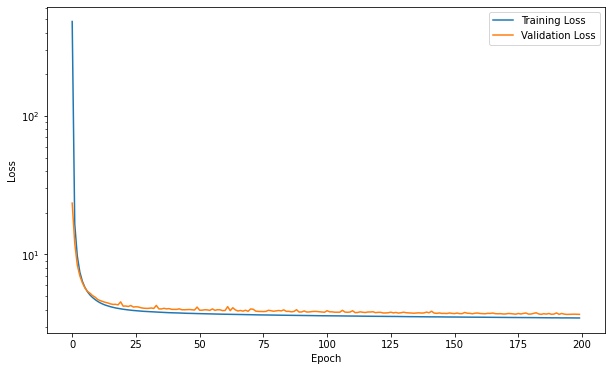

In [40]:
plt.rcParams["figure.figsize"] = (10,6)
mf.training_vs_validation_loss(fit_hist)

In [41]:
output = model.predict(ipd.clusters_v)

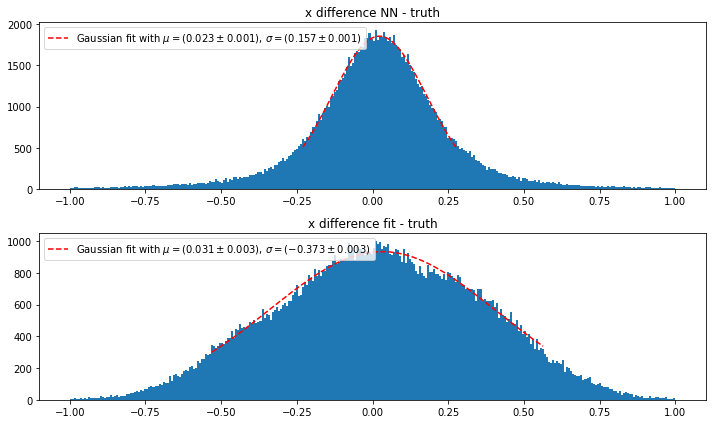

(array([2.25584804e-02, 1.57302785e-01, 7.31105807e+02]),
 array([9.31060031e-04, 1.22721164e-03, 4.58868566e+00]),
 array([ 3.14518854e-02, -3.73078158e-01,  8.73900140e+02]),
 array([2.50007670e-03, 3.49120271e-03, 6.53248271e+00]))

In [42]:
mf.histo_output(output.T[0], ipd.veri_fit.T[0], ipd.veri_truth.T[0], name="x", fit=True)

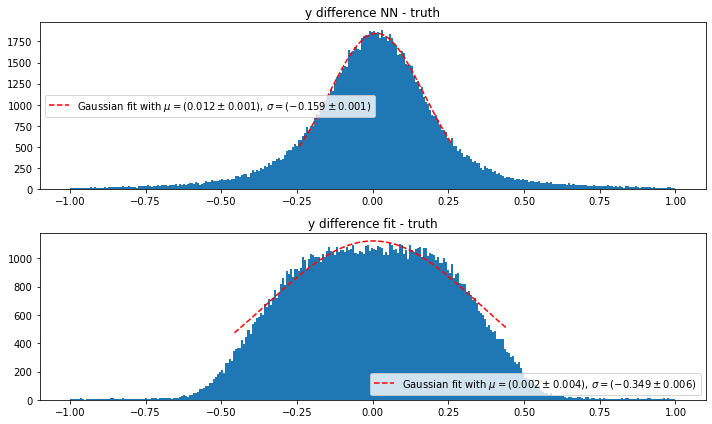

(array([ 1.23924406e-02, -1.58612206e-01,  7.33544028e+02]),
 array([8.62587592e-04, 1.14392278e-03, 4.25086684e+00]),
 array([ 1.90240960e-03, -3.48993734e-01,  9.82253393e+02]),
 array([3.60836947e-03, 5.75239045e-03, 1.28095452e+01]))

In [43]:
mf.histo_output(output.T[1], ipd.veri_fit.T[1], ipd.veri_truth.T[1], name="y")

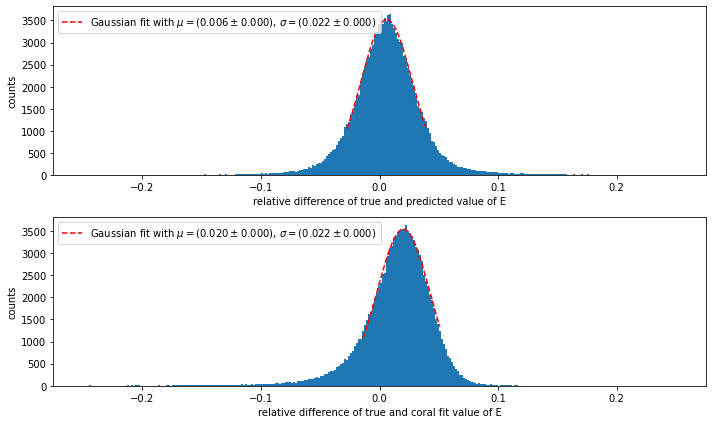

In [44]:
E_bad = mf.histo_output_relE(output.T[2], ipd.veri_fit.T[2], ipd.veri_truth.T[2], name="E", range_x=(-0.25,0.25), fit=True)

In [45]:
keras.models.save_model(model, 'stage3model_absolute_coord_input')

INFO:tensorflow:Assets written to: stage3model_absolute_coord_input/assets


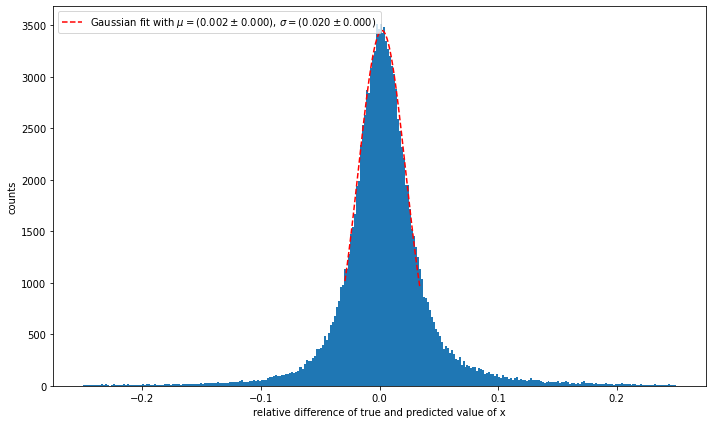

(array([ 9.8701421 , 13.33057197,  9.93450985, ..., 12.48333154,
         4.60683474,  9.7152053 ]),
 array([ 18.22453323,  12.80594486,  21.38119815, ...,  20.38086744,
        119.16951419, 162.48493812]))

In [46]:
mf.histo_output_relxy(output.T[0], ipd.veri_truth.T[0], ipd.veri_truth.T[2], name='x')

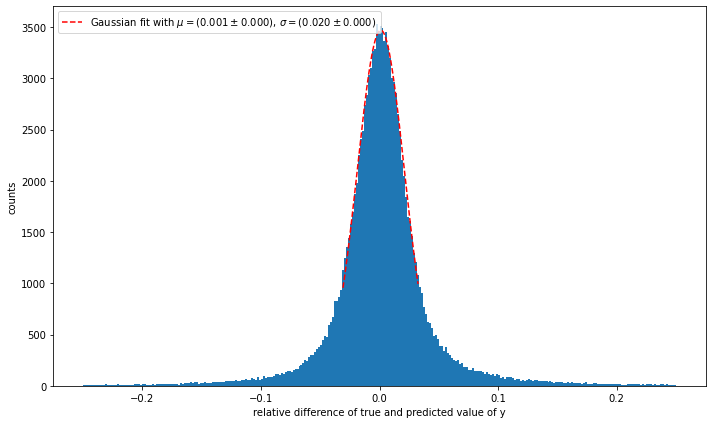

(array([ 7.0887408 ,  4.39929175,  4.4520767 , ...,  2.46870106,
         6.49541471, 10.60929609]),
 array([154.46788363,  18.22453323,  12.80594486, ...,  20.38086744,
        101.29088248,  74.52830215]))

In [47]:
mf.histo_output_relxy(output.T[1], ipd.veri_truth.T[1], ipd.veri_truth.T[2], name='y')

<h2> Result </h2>

Let's compare this!

| (x/y/rel E) | $\mu$ | $\sigma$ |
| --- | --- | --- |
| simple model stage 3 dataset 1| 0.023 / 0.00029 / 0.004 | 0.176 / 0.161 / 0.022 |
| simple model stage 3 dataset 2 | 0.017 / 0.006 / 0.004 | 0.320 / 0.196 / 0.022 |
| simple model stage 3 dataset 2 with absolute coordinates | 0.023 / 0.012 / 0.006 | 0.157 / 0.159 / 0.022 |

Yeay this is good! Looking at the relative differnece of x the network performs now good again (0.021/0.037/0.020)! Apperently the clusters are too small to learn the angles only from looking at the shape, so that the total position is required as well to learn the right correctment of position (as positions on the very left and very right have larger angles as the photons are propagated from the target).